In [1]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import tensorflow_hub as hub

In [2]:
# import mobilenet model
mobile_net = keras.applications.mobilenet_v2.MobileNetV2()

# model mobile_net summary
mobile_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [3]:
# shape of img
img_height, img_width = 224, 224

# initialization image data gen
image_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [4]:
# path dataset
dataset_path = '/content/drive/MyDrive/Dataset Ekspresi Kucing'
# batch size
batch_size = 32

# split to training
train_data = image_generator.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# split to validation
val_data = image_generator.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# print class the dataset we have
class_indices = train_data.class_indices
print('Class Indices:', class_indices)

Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Class Indices: {'Angry': 0, 'Sad': 1, 'happy': 2}


In [5]:
# download the headless model
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2

In [6]:
# create the feature extractor by wrapping the pre-trained model
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [7]:
# loop to fetch one batch
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 3)


In [8]:
# using feature extractor to get features
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [9]:
# downgrading TensorFlow, TensorFlow Hub, and Keras to compatible versions.
!pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [10]:
# initialization model use feature_extractor_layer
num_classes = len(class_indices)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [20]:
# compile model
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

In [21]:
# make custom callbacks for the model
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

In [22]:
# fit the model
history = model.fit(train_data, epochs=10,
                    validation_data=val_data,
                    callbacks=[batch_stats_callback])

Epoch 1/10
19/19 [==============================] - 227s 12s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.8543 - val_acc: 0.6267
Epoch 2/10
19/19 [==============================] - 35s 2s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.8040 - val_acc: 0.6733
Epoch 3/10
19/19 [==============================] - 36s 2s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.6910 - val_acc: 0.6933
Epoch 4/10
19/19 [==============================] - 36s 2s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.6266 - val_acc: 0.7533
Epoch 5/10
19/19 [==============================] - 40s 2s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.6074 - val_acc: 0.7133
Epoch 6/10
19/19 [==============================] - 36s 2s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.5470 - val_acc: 0.7867
Epoch 7/10
19/19 [==============================] - 37s 2s/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.5585 - val_acc: 0.7533
Epoch 8/10
19/19 [==============

In [23]:
# prediction
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
label_id = np.argmax(labels_batch, axis=-1)

1/1 [==============================] - 1s 1s/step


In [24]:
# classification report
print(classification_report(label_id, predicted_id, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.90      0.90      0.90        10
           2       0.86      0.92      0.89        13

    accuracy                           0.91        32
   macro avg       0.92      0.90      0.91        32
weighted avg       0.91      0.91      0.91        32



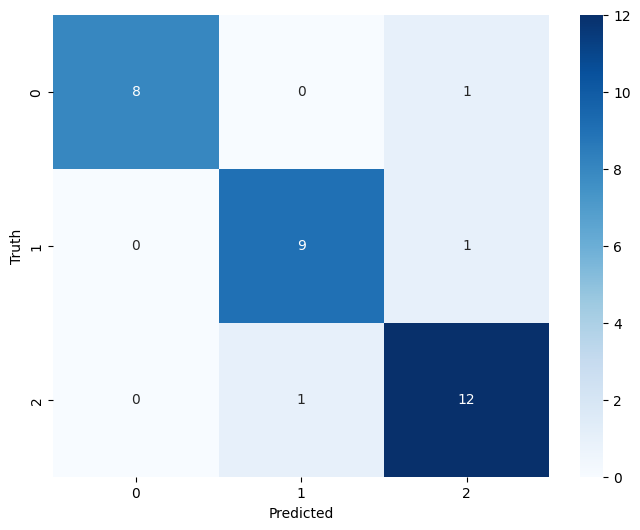

In [25]:
# confusion matrix
cm = tf.math.confusion_matrix(label_id, predicted_id)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

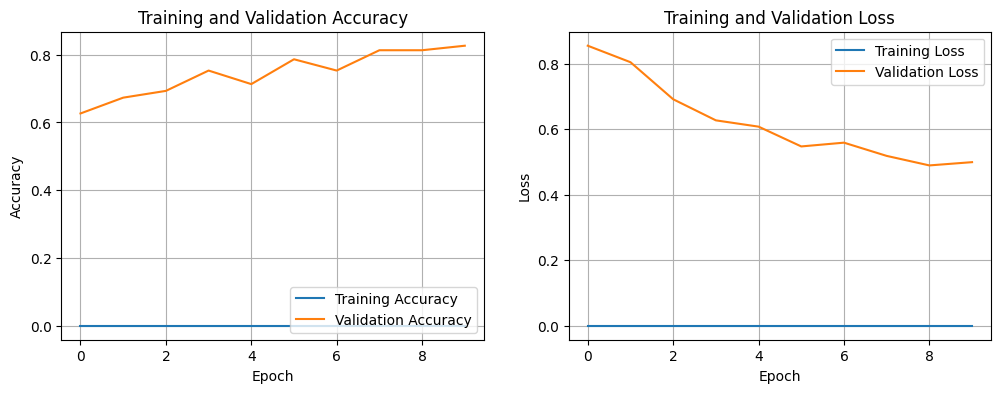

In [26]:
# visualize history for accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()

1/1 [==============================] - 1s 571ms/step


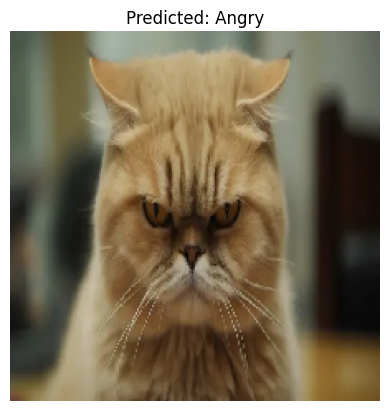

In [28]:
# make function for testing model
def predict_image(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    class_labels = list(train_data.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_label}')
    plt.show()
    return predicted_label

example_img_path = '/content/pngtree-an-angry-cat-looking-into-the-camera-image.jpg'
predicted_label = predict_image(example_img_path)

In [29]:
# save model
model.save('cat_expression_model.h5')